# CapPA inference demo

This notebook showcases how to use a CAPPA model.

In [1]:
# download model locally, if not already present (orbax not compatible with huggingface hub)
model_name = "boris/cappa-large-patch16-256-jax"
local_dir = "cappa-large-patch16-256-jax"
!huggingface-cli download {model_name} --local-dir {local_dir}

Fetching 11 files: 100%|█████████████████████| 11/11 [00:00<00:00, 10729.61it/s]
/home/boris/clip-jax/utils/cappa-large-patch16-256-jax


In [2]:
from functools import partial
from io import BytesIO
from pathlib import Path

import jax
import jax.numpy as jnp
import numpy as np
import orbax
import requests
from flax.training import orbax_utils
from flax.traverse_util import flatten_dict
from PIL import Image
from transformers import AutoTokenizer

from clip_jax import CLIPModel
from clip_jax.data import image_to_logits
from clip_jax.utils import load_config

## Loading a trained model

In [3]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
# load model
config_name = f"{local_dir}/config.json"
config = load_config(config_name)
config

{'text_config': {'float32_logits': True,
  'dtype': 'bfloat16',
  'activations': ['gelu', 'linear'],
  'normalize_qk': False,
  'use_bias': False,
  'force_scale': False,
  'attention_dropout': 0.0,
  'mlp_dropout_rate': 0.0,
  'unroll': 100,
  'remat_policy': 'none',
  'eos_token_id': 2,
  'mask_token_id': 4,
  'pad_token_id': 3,
  'bos_token_id': 1,
  'masked_pred_prob': 0.75,
  'is_decoder': True,
  'pool_type': None,
  'num_queries': 1,
  'vocab_size': 65536,
  'hidden_size': 1024,
  'max_length': 64,
  'num_layers': 12,
  'use_rmsnorm': True,
  'ln_type': 'normformer',
  'num_heads': 16,
  'position_embedding_type': 'rotary',
  'use_causal_mask': True,
  'mlp_dim': 3072},
 'vision_config': {'float32_logits': True,
  'position_embedding_type': 'learnt',
  'position_embedding_shape': None,
  'position_embedding_factorized': False,
  'dtype': 'bfloat16',
  'activations': ['gelu', 'linear'],
  'normalize_qk': False,
  'use_bias': False,
  'force_scale': False,
  'attention_dropout': 0

In [5]:
# load model
model = CLIPModel(**config)

In [6]:
# initialize model
rng = jax.random.PRNGKey(0)
logical_shape = jax.eval_shape(lambda rng: model.init_weights(rng), rng)["params"]
params = jax.tree.map(lambda x: jnp.zeros(x.shape, dtype=x.dtype), logical_shape)

In [7]:
# we can quickly explore shape of params
# NOTE: "logit_bias" and "logit_scale" are actually not used for inference
jax.tree.map(lambda x: x.shape, params)

{'logit_bias': LogicallyPartitioned(value=(1,), names=(None,), mesh=None, rules=None),
 'logit_scale': LogicallyPartitioned(value=(1,), names=(None,), mesh=None, rules=None),
 'text': {'embeddings': {'embeddings': {'embedding': LogicallyPartitioned(value=(65536, 1024), names=('vocab', 'embed'), mesh=None, rules=None)}},
  'encoder': {'layers': {'attention': {'key': {'kernel': LogicallyPartitioned(value=(12, 1024, 16, 64), names=('layers', 'embed', 'heads', 'kv'), mesh=None, rules=None)},
     'out': {'kernel': LogicallyPartitioned(value=(12, 16, 64, 1024), names=('layers', 'heads', 'kv', 'embed'), mesh=None, rules=None)},
     'query': {'kernel': LogicallyPartitioned(value=(12, 1024, 16, 64), names=('layers', 'embed', 'heads', 'kv'), mesh=None, rules=None)},
     'value': {'kernel': LogicallyPartitioned(value=(12, 1024, 16, 64), names=('layers', 'embed', 'heads', 'kv'), mesh=None, rules=None)}},
    'cross_attention': {'key': {'kernel': LogicallyPartitioned(value=(12, 1024, 16, 64), na

In [8]:
# get model checkpoint
model_path = str(Path(local_dir).resolve())
model_path

'/home/boris/clip-jax/utils/cappa-large-patch16-256-jax'

In [9]:
# restore checkpoint
ckpt = {"params": params}
restore_args = orbax_utils.restore_args_from_target(ckpt)
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
orbax_options = orbax.checkpoint.CheckpointManagerOptions()
checkpoint_manager = orbax.checkpoint.CheckpointManager(model_path, orbax_checkpointer, orbax_options)
step = checkpoint_manager.latest_step()
ckpt = checkpoint_manager.restore(step, ckpt, restore_kwargs={"restore_args": restore_args, "transforms": {}})
params = ckpt["params"]

In [10]:
# ensure params have been set
for k, v in flatten_dict(params).items():
    if jnp.sum(jnp.abs(v.value)) == 0:
        print(f"Warning: {k} has not been set")

## Inference

The purpose of the CapPa model is not to be used directly but discard the text tower and keep only the vision tower for downstream applications.

However we can still perform inference on the model for fun.

In [11]:
@partial(
    jax.jit,
    static_argnames=("num_beams", "do_sample", "temperature", "top_p", "top_k", "max_length", "num_return_sequences"),
)
def generate_caption(pixel_values, *args, **kwargs):
    return model.generate(pixel_values, *args, **kwargs)


def caption(*args, **kwargs):
    outputs = generate_caption(*args, **kwargs)
    res = outputs.sequences
    return tokenizer.batch_decode(res, skip_special_tokens=True)

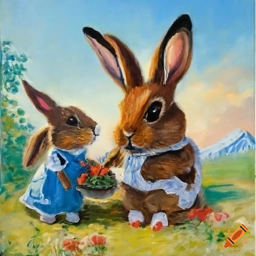

In [12]:
# image data
img_url = "https://pics.craiyon.com/2023-07-15/452a619911e1404e8b3cb0199e2e0907.webp"

response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img = img.resize((256, 256))
img = img.convert("RGB")
# image inference
pixel_values = image_to_logits(img)
pixel_values = pixel_values[np.newaxis, ...]
img

The first time we generate a caption with specific settings, it will be slow due to compilation but then it goes fast.

In [13]:
caption(pixel_values, params=params, num_beams=4)

[' " the rabbit family "']

In [14]:
caption(pixel_values, params=params, num_beams=4, num_return_sequences=4)

[' " the rabbit family "',
 ' the rabbit and the rabbit',
 ' the rabbit and the hare',
 ' the rabbit and the bunny']

In [15]:
# sampling
caption(pixel_values, params=params, do_sample=True, temperature=0.7, prng_key=rng)

[' easter bunny family painting']

In [16]:
# sampling with updated random key for different results
for _ in range(10):
    rng, _ = jax.random.split(rng)
    res = caption(pixel_values, params=params, do_sample=True, temperature=0.7, prng_key=rng)
    print(res)

[' easter bunnies']
[' rabbit painting']
[' little bunny']
[' garden bunnies']
[' easter bunnies']
[' the rabbit family']
[' art, bunny love by artist elaine duras']
[' bunny couple']
[' the rabbit family']
[' bunny painting']


## Logits prediction

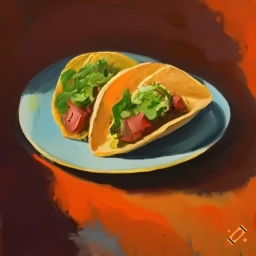

In [17]:
# image inputs
img_url = "https://pics.craiyon.com/2023-07-03/6fab1a12820a49c9a51aacd3cf7f139b.webp"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
img = img.resize((256, 256))
img = img.convert("RGB")
pixel_values = image_to_logits(img)
pixel_values = pixel_values[np.newaxis, ...]
img

In [18]:
# text inputs
text = "painting of tacos"
text_inputs = tokenizer(text, return_tensors="np", padding="max_length", max_length=config["text_config"]["max_length"], truncation=True)
text_inputs = {"input_ids": text_inputs["input_ids"], "attention_mask": text_inputs["attention_mask"]}

In [19]:
# prepare batch
batch = {"pixel_values": pixel_values, **text_inputs}
jax.tree.map(lambda x: x.shape, batch)

{'attention_mask': (1, 64),
 'input_ids': (1, 64),
 'pixel_values': (1, 256, 256, 3)}

In [20]:
# inference (note: can jit it for faster inference after first compilation)
res = model.apply({"params": params}, **batch)

In [21]:
# NOTE: relevant keys are "text_model_output" and "vision_model_output"
jax.tree.map(lambda x: x.shape, res)

{'image_embeds': None,
 'logit_bias': (1,),
 'logit_scale': (1,),
 'logits_per_image': None,
 'logits_per_text': None,
 'text_embeds': None,
 'text_model_output': {'last_hidden_state': (1, 64, 65536),
  'pooled_output': None},
 'vision_model_output': {'last_hidden_state': (1, 264, 1024),
  'pooled_output': None}}

In [22]:
# capture intermediate values
# NOTE: to add attention logits you need to manually edit MultiHeadDotProductAttention and set "sow_weights=True"
output, mod_vars = model.apply(
    {"params": params},
    **batch,
    capture_intermediates=True, mutable=["intermediates"]
)

jax.tree.map(lambda x: x.shape, mod_vars["intermediates"])

{'__call__': ({'image_embeds': None,
   'logit_bias': (1,),
   'logit_scale': (1,),
   'logits_per_image': None,
   'logits_per_text': None,
   'text_embeds': None,
   'text_model_output': {'last_hidden_state': (1, 64, 65536),
    'pooled_output': None},
   'vision_model_output': {'last_hidden_state': (1, 264, 1024),
    'pooled_output': None}},),
 'text': {'__call__': ({'last_hidden_state': (1, 64, 65536),
    'pooled_output': None},),
  'embeddings': {'__call__': ((1, 64, 1024),),
   'embeddings': {'__call__': ((1, 64, 1024),)}},
  'encoder': {'__call__': ({'last_hidden_state': (1, 64, 1024)},),
   'layers': {'__call__': (((12, 1, 64, 1024), None),),
    'attention': {'__call__': ((12, 1, 64, 1024),),
     'key': {'__call__': ((12, 1, 64, 16, 64),)},
     'key_rotary': {'__call__': ((12, 1, 64, 16, 64),)},
     'out': {'__call__': ((12, 1, 64, 1024),)},
     'query': {'__call__': ((12, 1, 64, 16, 64),)},
     'query_rotary': {'__call__': ((12, 1, 64, 16, 64),)},
     'value': {'__cal